In [1]:
!nvidia-smi


Fri Jan 12 12:30:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
Face Expression Recognition using CNN Model and pytorch library

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

Import the database into Google Colab

In [3]:
from google.colab import files
import zipfile

# Téléchargez le fichier zip depuis votre ordinateur local
uploaded = files.upload()

# Spécifiez le nom du fichier zip
Database_zip = list(uploaded.keys())[0]

# Extrayez le contenu du fichier zip dans le répertoire de destination
with zipfile.ZipFile(Database_zip, 'r') as zip_ref:
    zip_ref.extractall("Database")


Saving archive.zip to archive.zip


Loading the data

In [4]:
TRAIN_DIR = '/content/Database/train/'
TEST_DIR = '/content/Database/test/'

The load_dataset function takes a directory path as input and retrieves paths to individual image files along with their corresponding labels. It iterates through subdirectories, collects image paths, and labels, and returns these lists. This function is designed for loading image datasets organized by subdirectories, where each subdirectory represents a distinct class.

In [5]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return image_paths, labels

The code initializes a pandas DataFrame named train and fills it with image paths and labels using the load_dataset function. The dataset is then shuffled, and the first few rows are displayed using head()

In [6]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

disgust Completed
happy Completed
sad Completed
neutral Completed
fear Completed
surprise Completed
angry Completed


,image,label
0,/content/Database/train/angry/Training_4667506...,angry
1,/content/Database/train/surprise/Training_1727...,surprise
2,/content/Database/train/neutral/Training_96846...,neutral
3,/content/Database/train/happy/Training_8802687...,happy
4,/content/Database/train/neutral/Training_18579...,neutral


The code initializes a new pandas DataFrame named test by populating it with image paths and labels using the load_dataset function for the testing dataset. It then displays the first few rows of the test DataFrame.

In [7]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

disgust Completed
happy Completed
sad Completed
neutral Completed
fear Completed
surprise Completed
angry Completed


,image,label
0,/content/Database/test/disgust/PublicTest_3919...,disgust
1,/content/Database/test/disgust/PrivateTest_392...,disgust
2,/content/Database/test/disgust/PublicTest_1145...,disgust
3,/content/Database/test/disgust/PublicTest_2046...,disgust
4,/content/Database/test/disgust/PrivateTest_987...,disgust


This code ensures that the 'label' column in the 'train' DataFrame is treated as a categorical variable by converting its data type to 'category'. It then creates a countplot using seaborn (sns) to visualize the distribution of different categories in the 'label' column of the 'train' DataFrame. The x-axis represents the categories, and the y-axis represents the count of occurrences of each category.

<Axes: xlabel='label', ylabel='count'>

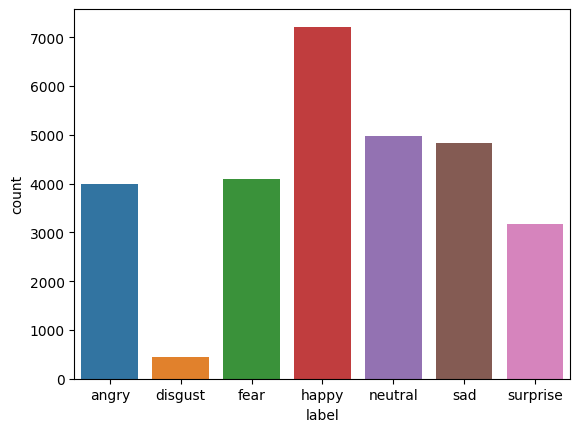

In [8]:

# Ensure the 'label' column is of type 'category'
train['label'] = train['label'].astype('category')

# Plot the countplot
sns.countplot(data=train, x='label')



This code uses the Python Imaging Library (PIL) module, now known as Pillow (from PIL import Image), to open an image from the 'image' column of the 'train' DataFrame. The image is then displayed using Matplotlib (plt.imshow) with a grayscale colormap (cmap='gray').

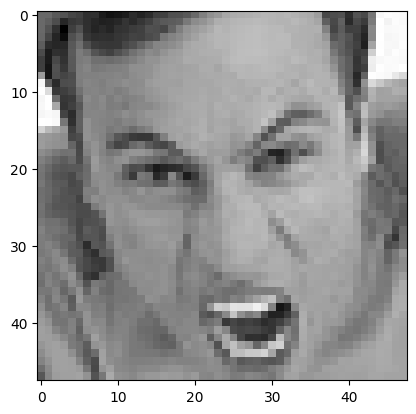

In [9]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray')


The code generates a 5x5 grid of subplots, displaying the first 25 images from the 'train' DataFrame along with their corresponding labels. Each subplot contains an image loaded from its file path, and the title of each subplot indicates the image's label. The x and y axes are turned off for better visualization.

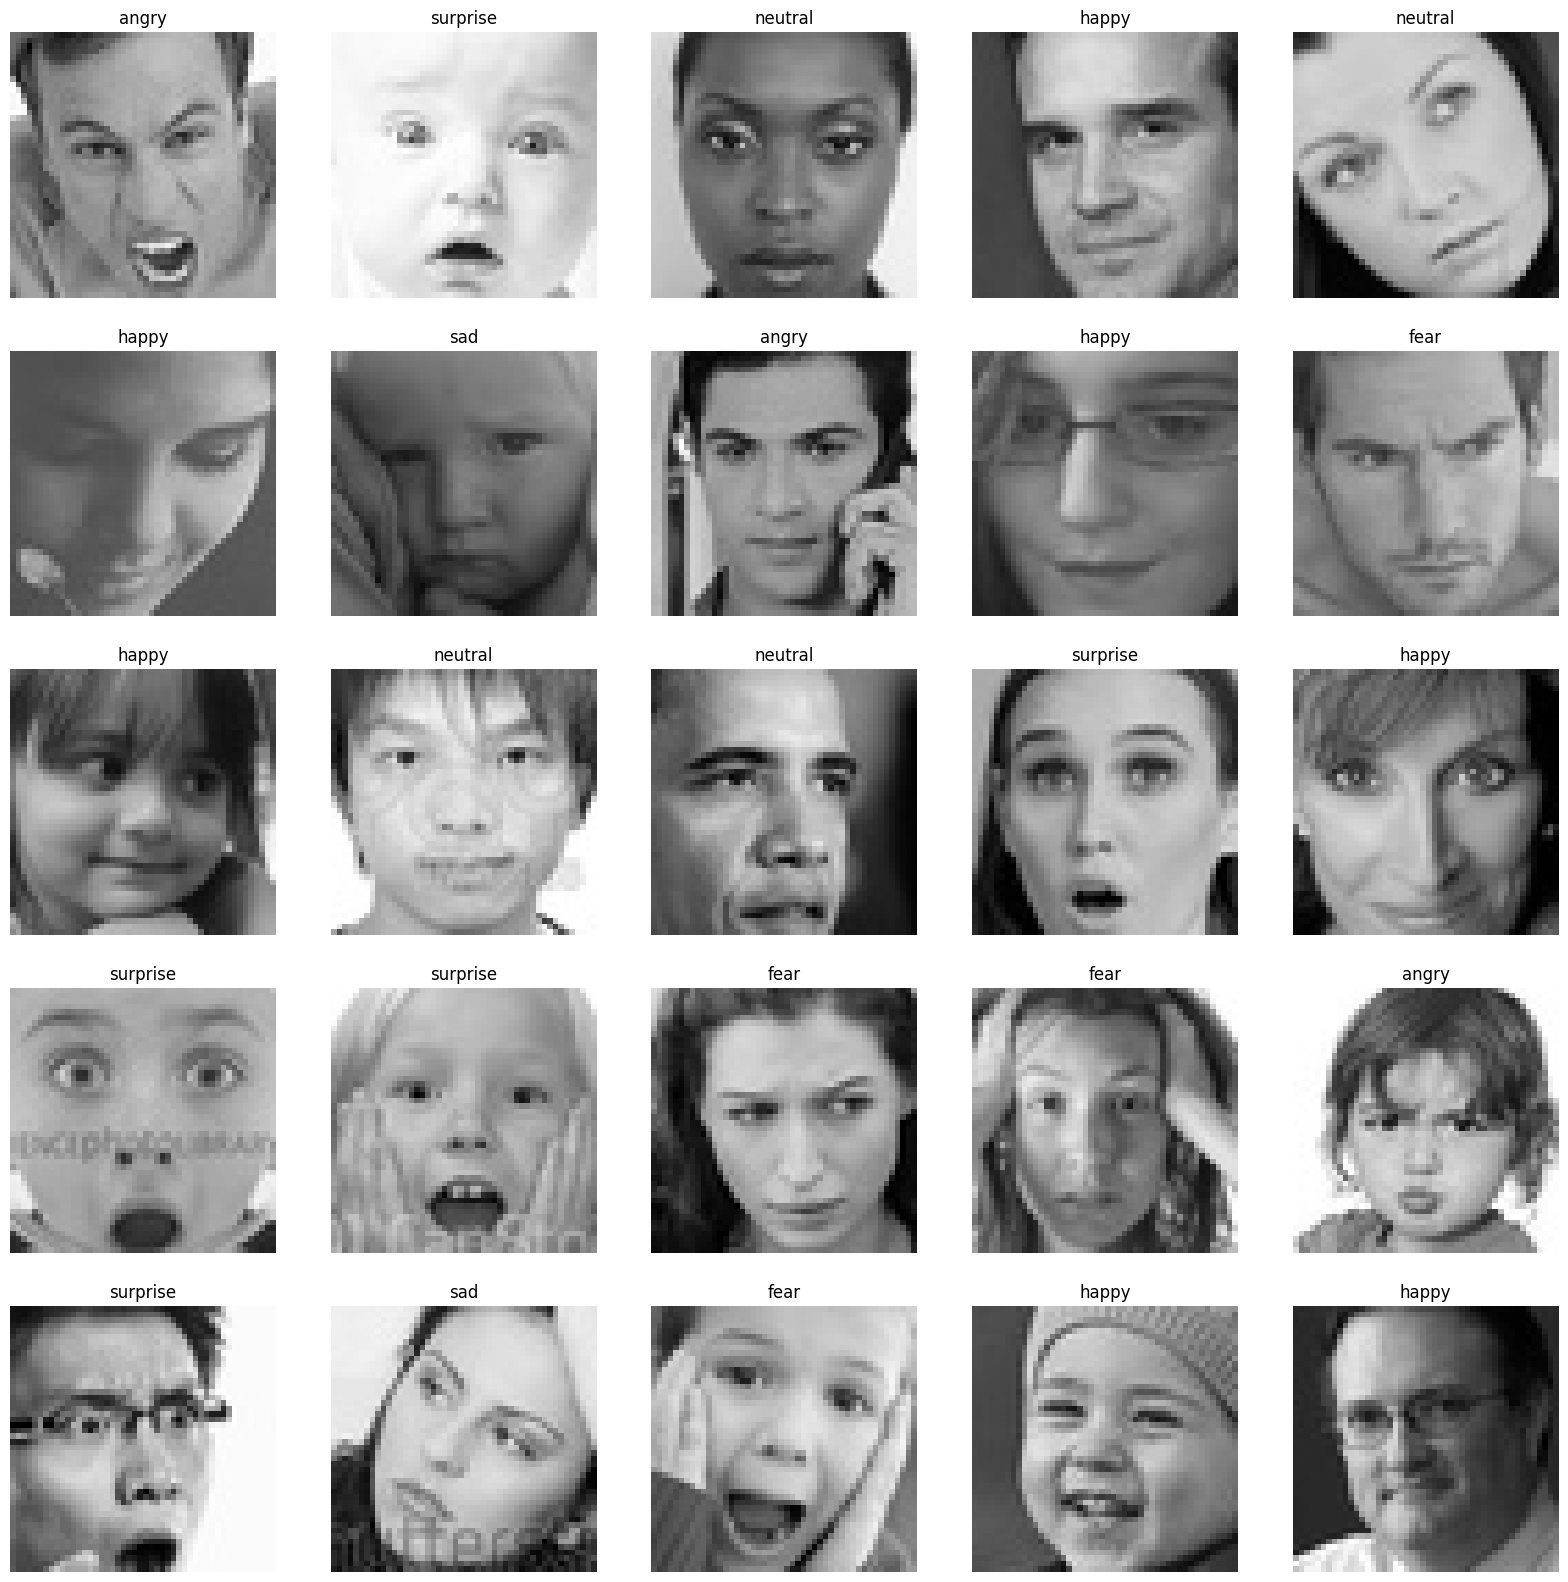

In [10]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')


The code defines a function named extract_features that takes a list of image paths (images) as input, loads each image, and appends its grayscale representation to a list named features. The function utilizes the tqdm library to create a progress bar for tracking the iteration progress. The resulting grayscale images are reshaped into a NumPy array before being returned.

In [11]:
from tqdm import tqdm  # Import tqdm instead of tqdm_notebook
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features


This line of code applies the extract_features function to the 'image' column of the 'train' DataFrame, generating a NumPy array named train_features. The function processes each image path from the DataFrame, loads the corresponding grayscale images, and compiles them into the 'train_features' array.

In [12]:
train_features = extract_features(train['image'])

100%|██████████| 28709/28709 [00:04<00:00, 6959.92it/s]



This line of code applies the extract_features function to the 'image' column of the 'test' DataFrame, generating a NumPy array named test_features. The function processes each image path from the DataFrame, loads the corresponding grayscale images, and compiles them into the 'test_features' array.

In [13]:
test_features = extract_features(test['image'])

100%|██████████| 7178/7178 [00:01<00:00, 5191.97it/s]


This code normalizes the pixel values of the grayscale images in train_features and test_features. The normalization is done by dividing each pixel value by 255.0, which scales the pixel values to a range between 0 and 1. This is a common preprocessing step in machine learning to ensure that the input data falls within a consistent and manageable range.

In [14]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

This code snippet utilizes the LabelEncoder from scikit-learn to convert the categorical labels in the 'label' column of the 'train' and 'test' DataFrames to integer labels. The process involves fitting the encoder to the unique labels in the training set and transforming both training and testing labels accordingly. The transformed labels are stored in the variables y_train for the training set and y_test for the testing set.

In [15]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

The code uses the to_categorical function to one-hot encode the integer labels (y_train and y_test) into categorical format. This is a common step in machine learning when dealing with categorical data. The num_classes parameter is set to 7, assuming there are 7 classes in the dataset. One-hot encoding transforms each integer label into a binary vector, where each class is represented by a unique binary digit.

In [16]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

The expression y_train[0] retrieves the one-hot encoded label for the first training sample in your dataset. It returns a binary vector where each element represents the presence or absence of a specific class. The value of 1 indicates the presence of the corresponding class, and 0 indicates absence.

In [17]:
y_train[0]

array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)


The code sets the input_shape variable to (48, 48, 1), representing the dimensions of input images (48 pixels in height, 48 pixels in width, and 1 channel for grayscale). The output_class variable is set to 7, indicating the number of classes in the classification task.

In [18]:
# config
input_shape = (48, 48, 1)
output_class = 7

This code defines a Convolutional Neural Network (CNN) model using the Sequential API in Keras. Here's a brief description of each layer:

1- Convolutional Layers:

The model starts with a convolutional layer with 128 filters, a kernel size of (3,3), ReLU activation, and the specified input shape.
A max pooling layer with a pool size of (2,2) follows the first convolutional layer, reducing spatial dimensions.
A dropout layer with a dropout rate of 0.4 helps prevent overfitting.
This pattern repeats with additional convolutional layers, max pooling, and dropout for model depth and feature extraction.

2- Flatten Layer:

Flattens the output from the convolutional layers into a one-dimensional array for input to the fully connected layers.

3- Fully Connected Layers:

Two dense (fully connected) layers with 512 and 256 neurons, ReLU activation, and dropout are added for feature processing.
The final dense layer with output_class neurons and softmax activation produces output probabilities for each class.

4- Model Compilation:

The model is compiled using the Adam optimizer, categorical crossentropy loss (suitable for multiclass classification), and accuracy as the metric.
This architecture is a common pattern for image classification tasks using CNNs.

In [19]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

Training the Cnn Model

In [20]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
225/225 [==============================] - 24s 64ms/step - loss: 1.8242 - accuracy: 0.2486 - val_loss: 1.8130 - val_accuracy: 0.2471
Epoch 2/100
225/225 [==============================] - 12s 54ms/step - loss: 1.8021 - accuracy: 0.2544 - val_loss: 1.7908 - val_accuracy: 0.2549
Epoch 3/100
225/225 [==============================] - 12s 55ms/step - loss: 1.7456 - accuracy: 0.2749 - val_loss: 1.6574 - val_accuracy: 0.3377
Epoch 4/100
225/225 [==============================] - 12s 55ms/step - loss: 1.6362 - accuracy: 0.3498 - val_loss: 1.4920 - val_accuracy: 0.4191
Epoch 5/100
225/225 [==============================] - 13s 60ms/step - loss: 1.5304 - accuracy: 0.4016 - val_loss: 1.4020 - val_accuracy: 0.4593
Epoch 6/100
225/225 [==============================] - 13s 59ms/step - loss: 1.4583 - accuracy: 0.4378 - val_loss: 1.3433 - val_accuracy: 0.4760
Epoch 7/100
225/225 [==============================] - 13s 58ms/step - loss: 1.4086 - accuracy: 0.4567 - val_loss: 1.3085 - val_ac

Saving the trained model

In [32]:
import torch
# Save the entire PyTorch model
torch.save(model, '/content/model.pt')

This code creates two subplots to visualize the training and validation performance of a neural network over epochs.
These visualizations are helpful for understanding how well the model is learning from the training data and generalizing to unseen validation data across epochs.

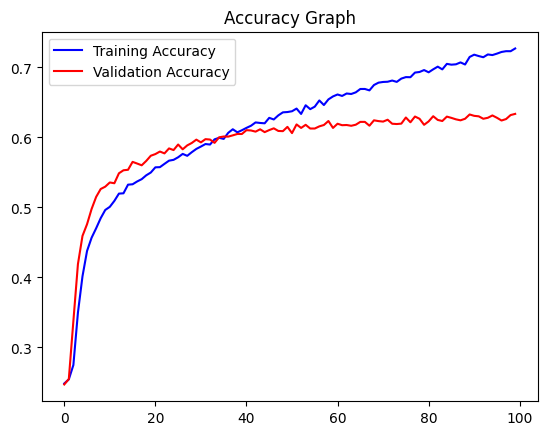

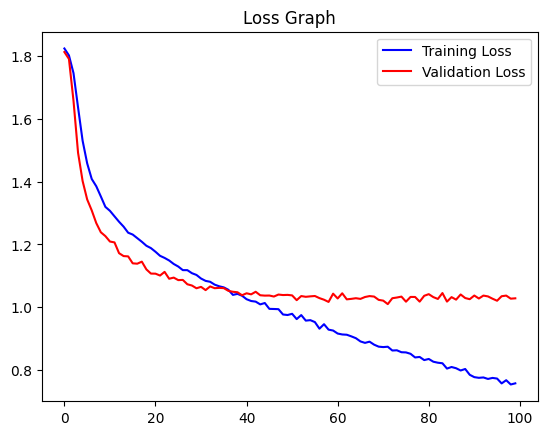

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

Testing the model with images

Original Output: neutral
1/1 [==============================] - 0s 410ms/step
Predicted Output: neutral


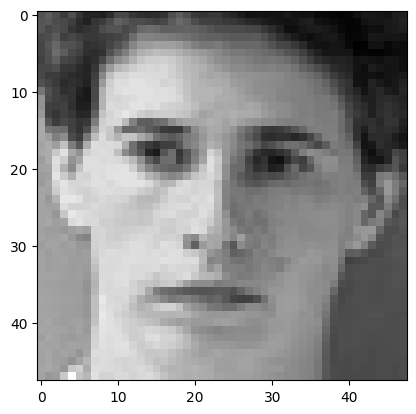

In [22]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray')

Original Output: fear
1/1 [==============================] - 0s 19ms/step
Predicted Output: fear


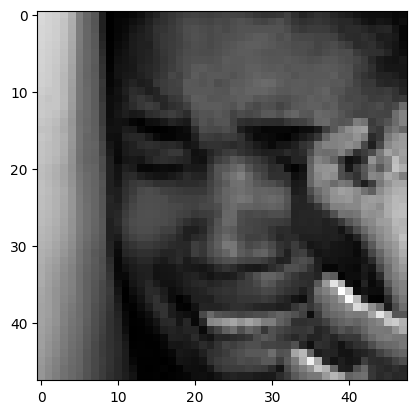

In [24]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: angry
1/1 [==============================] - 0s 17ms/step
Predicted Output: angry


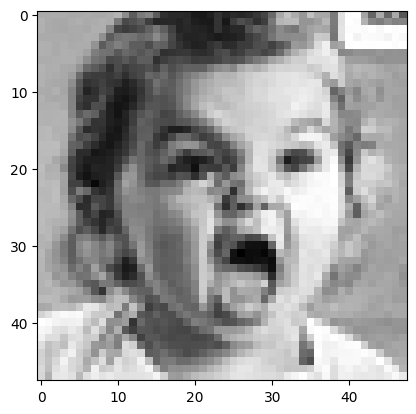

In [26]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');